In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain-openai langchain-community


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

In [4]:
#Basic Chatbot
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

**Notice** that we've defined our `State` as a TypedDict with a single key: `messages`. The `messages` key is annotated with the [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) function, which tells LangGraph to append new messages to the existing list, rather than overwriting it.

In [5]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [6]:
#Next, add an `entry` point. This tells our graph **where to start its work** each time we run it.
graph_builder.set_entry_point("chatbot")

In [8]:
#Similarly, set a `finish` point. This instructs the graph **"any time this node is run, you can exit."**
graph_builder.set_finish_point("chatbot")

In [9]:
graph = graph_builder.compile()

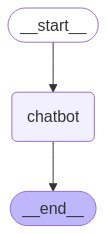

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [12]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        print(event['chatbot']['messages'])
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

[AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_90d33c15d4', 'id': 'chatcmpl-BCXCeOvHVWN92QCfMIhMIkXsI1Q9B', 'finish_reason': 'stop', 'logprobs': None}, id='run-80cc6862-0884-426e-8cec-1307912a581f-0', usage_metadata={'input_tokens': 9, 'output_tokens': 10, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]
Assistant: Hello! How can I assist you today?
[AIMessage(content="Budapest, the capital city of Hungary, experiences a temperate continental climate with distinct seasons. Here's a brief overview of 

In [13]:
from langchain_core.messages import HumanMessage
graph.invoke({"messages": [HumanMessage(content="Hello, world!")]})

{'messages': [HumanMessage(content='Hello, world!', additional_kwargs={}, response_metadata={}, id='8dfbfb13-22e6-44a5-a599-95b9a7492fae'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 11, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_90d33c15d4', 'id': 'chatcmpl-BCXDSLY4fX1j4jx9C27lD2CqYznE8', 'finish_reason': 'stop', 'logprobs': None}, id='run-1ce0c493-9f9d-48c9-9656-60f232614d86-0', usage_metadata={'input_tokens': 11, 'output_tokens': 10, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}